# 4.1 Kernel PCA: Toy Data

Group name: DataFun

Members:
    Fabian Frank,
    David Munkacsi,
    Jan Botsch,

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la

from scipy.spatial.distance import cdist

### (a) Create toy dataset

(90, 2)


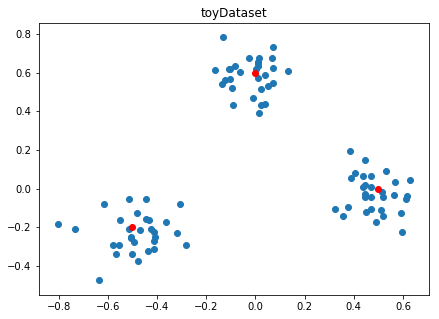

In [102]:
xMean = np.asarray([[-0.5, -0.2],[0, 0.6],[0.5, 0]])
sd = 0.1
toyDataset = np.empty([0,2])
for mean in xMean:
    toyDatasetPart = np.random.normal(mean, sd, [30,2])
    toyDataset = np.concatenate((toyDataset, toyDatasetPart), axis=0)

print(toyDataset.shape)

# Plotting the results.
plt.figure(figsize=(7,5))
plt.scatter(toyDataset[:,0], toyDataset[:,1])
plt.scatter(xMean[:,0], xMean[:,1], color="r")
plt.title("toyDataset")
plt.show()

### (b) Apply Kernel PCA using RBF Kernel

In [103]:
def k(x_a, x_b, sig):
    norm = np.linalg.norm(x_a - x_b)
    return np.exp(- norm**2 / (2*sig**2))
    
def createKernelMatrix(x, sig):
    p = x.shape[0] 
    KUnnormalized = np.empty([p,p])
    for i in range(p):
        for j in range(p):
            KUnnormalized[i,j] = k(x[i], x[j], sig)
    return KUnnormalized

def centerKernelMatrix(KUC):
    p = KUC.shape[0] 
    K = np.empty([p,p])
    rowAverages = np.average(KUC, axis=0)
    lineAverages = np.average(KUC, axis=1)
    matrixAverge = np.average(KUC)
    for i in range(p):
        for j in range(p):
            K[i,j] = KUC[i,j] - rowAverages[i] - lineAverages[j] + matrixAverge
    return K


sig = 0.1
KernelMatrixUnnormalized = createKernelMatrix(toyDataset, sig)
print("unnormalized KM shape: ", KernelMatrixUnnormalized.shape)
centerdKernelMatrixUnnormalized = centerKernelMatrix(KernelMatrixUnnormalized)
print("centered KM shape:", centerdKernelMatrixUnnormalized.shape)

def getOrderedEig(matrix):
    eigenvals, eigenvecs = np.linalg.eig(matrix)
    orderedInd = np.argsort(eigenvals)[::-1]
    orderedEigenvals = eigenvals[orderedInd]
    orderedEigenvecs = eigenvecs[orderedInd]
    return (orderedEigenvals, orderedEigenvecs)

orderedEigenvalues, orderedEigenvectors = getOrderedEig(centerdKernelMatrixUnnormalized)
print("orderedEigenvectors.shape:", orderedEigenvectors.shape)

def normalizeEV(orderedEigenvals, orderedEigenvecs):
    p = orderedEigenvals.shape[0]
    normEV = np.empty([p,p])
    for i in range(p):
        normEV = orderedEigenvecs / np.sqrt(p*orderedEigenvals[i])
    return normEV

normalizedEigenvectors = normalizeEV(orderedEigenvalues, orderedEigenvectors)
print("normalizeEigenvectors.shape:", normalizedEigenvectors.shape)


unnormalized KM shape:  (90, 90)
centered KM shape: (90, 90)
orderedEigenvectors.shape: (90, 90)
normalizeEigenvectors.shape: (90, 90)


Normalized eigenvectors:

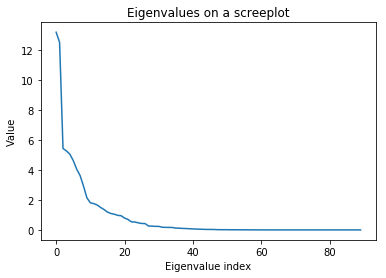

In [104]:
plt.figure()
plt.plot(orderedEigenvalues)
plt.xlabel("Eigenvalue index")
plt.ylabel("Value")
plt.title("Eigenvalues on a screeplot")
plt.show()

Data projected on PC1 and PC2

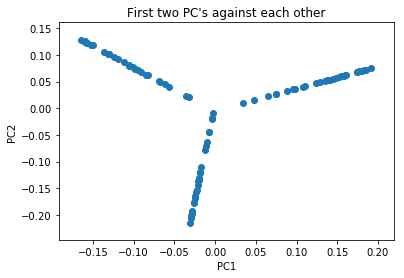

In [105]:
plt.figure()
plt.scatter(orderedEigenvectors[:,0], orderedEigenvectors[:,1])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("First two PC's against each other")
plt.show()

### (c) Visualize first 8 PC

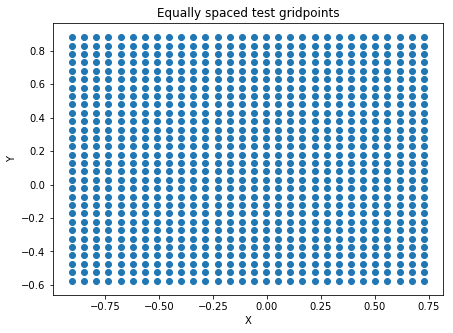

In [106]:
# Creating the test data (equally spaced gridpoints).
# Acquiring maximal and minimal values of our toy data, to be able to define
# a space.
minX, minY = np.min(toyDataset,0)
maxX, maxY = np.max(toyDataset, 0)

# Dividing the space linear. Have to add deviation.
sd=0.1
x = np.linspace(minX-sd,maxX+sd,30)
y = np.linspace(minY-sd,maxY+sd,30)

# Return coordinate matrices from coordinate vector.
xv,yv = np.meshgrid(x,y)

# Plotting the grid.
plt.figure(figsize=(7,5))
plt.scatter(xv,yv)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Equally spaced test gridpoints')
plt.show()

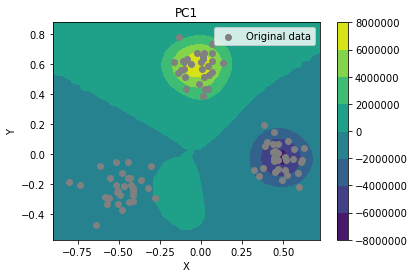

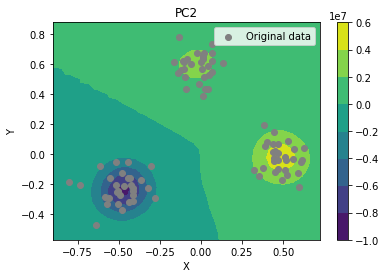

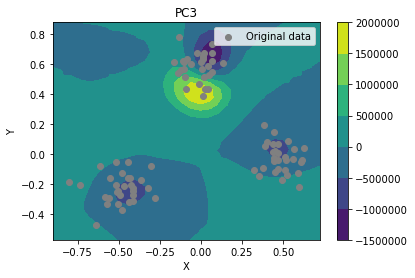

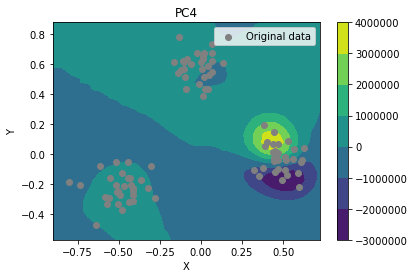

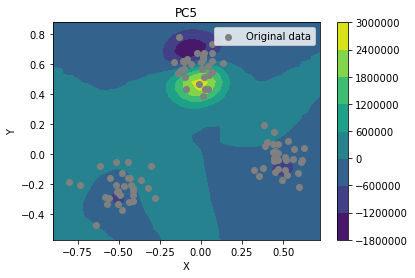

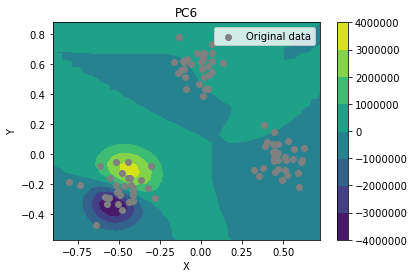

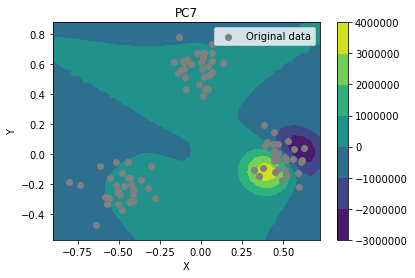

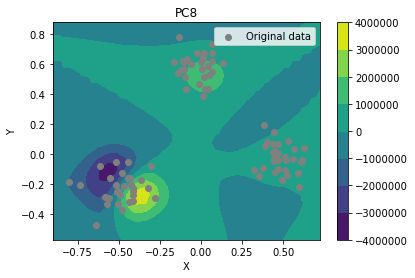

In [108]:
# Goal: Reshaping 30x30 matrixes into 900x2 vectors.
# Reshaping to one dimensional vectors.
xVec = np.reshape(xv,(30*30,1))
yVec = np.reshape(yv,(30*30,1))
# Concatanating the previous vectors.
meshgrid = np.concatenate((xVec,yVec),1)

# Calculating difference between test data and sample data.
# Third parameter means that we count the squared euclidean distance
# (what we need for RBF kernel).
newKernelMatrix = np.exp(-(cdist(meshgrid,toyDataset,'sqeuclidean'))/(2*sig*sig))

# The new kernel matrix is 900x90 (#TData X #SampleData).
# Centering the new kernel matrix with the known formula.
rowAvg = np.average(newKernelMatrix, axis=0)[None,:]
colAvg = np.average(newKernelMatrix, axis=1)[:,None]
matrixAvg = np.average(newKernelMatrix)
centeredNewKernelMatrix = newKernelMatrix - rowAvg - colAvg - matrixAvg

# Project onto the first 8 PCs using matrix multiplication operator.
# 900x90 @ 90x8 = 90x8
requiredPCs = normalizedEigenvectors[:,0:8]
projection = newKernelMatrix @ requiredPCs

for i in range(0,8):
    plt.figure()
    plt.contourf(xv, yv, np.reshape(projection[:,i],((30,30))))
    plt.colorbar()
    plt.scatter(toyDataset[:,0],toyDataset[:,1],c='grey',label='Original data')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('PC'+str(i+1))
    plt.legend()
    plt.show()

### (d) Discuss suitable applications for KPCA